###**100m**
###**batch size - 128**
###**reverse filter order**

####**dependencies + packages**

In [1]:
! pip install keras --upgrade
! pip install tensorflow --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.0)


In [2]:
from keras import Input, Model, layers, models, optimizers
from keras.backend import clear_session
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.datasets import fashion_mnist
from keras.layers import concatenate, Dropout
from keras.losses import categorical_crossentropy
from keras.models import load_model, model_from_json, Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


####**functions**

In [4]:
def calc_moving_average(x, w):
  num_timesteps = x[0].shape[0] - w
  num_dims = x.shape[2]

  new_array = np.zeros(shape= (x.shape[0], num_timesteps, num_dims))
  for i in range(len(x)):
    for j in range(num_dims):
      array = x[:, :, j][i]
      moving_avg = np.convolve(array, np.ones(w), 'valid') / w
      new_array[:, :, j][i] = moving_avg[:num_timesteps]
    
  return new_array

def calc_classification_report(y_pred, y_test):
  predicted_labels = np.argmax(y_pred, axis= 1)
  # get labels in y_test
  labels = np.argmax(y_test, axis= 1)

  print(classification_report(predicted_labels, labels))

# create bins
def create_bins(series, bins, labels):
  return pd.cut(series, bins = bins, labels = labels)

def create_confusion_matrix(y_pred, y_test):
  predicted_labels = np.argmax(y_pred, axis= 1)
  # get labels in y_test
  labels = np.argmax(y_test, axis= 1)
  
  # convert to series
  y_actu = pd.Series(labels, name = 'actual')
  y_pred = pd.Series(predicted_labels, name = 'predicted')
  # create confusion matrix
  df_confusion = pd.crosstab(y_actu, y_pred, margins = True)
  df_confusion_normal = pd.crosstab(y_actu, y_pred, margins = True, normalize = 'all')
  
  print('confusion matrix : \n{}\n'.format(df_confusion))
  print('confusion matrix (normalize): \n{}'.format(df_confusion_normal))

def create_lookback(dataset, num_rows, look_back):
  data = np.zeros(shape = (dataset.shape[0], num_rows, look_back))

  for i in range(len(data)):
    for j in range(num_rows):
      data[i][j] = dataset[i][j:(j+look_back)]

  return data

def create_matrix(dataset):
  # create matrix that will contain data
  trips = dataset[0].shape[0]
  rows = dataset[0].shape[1]
  cols = len(dataset)

  merged = np.zeros(shape= (trips, rows, cols))
  merged.shape

  for i in range(len(dataset)):
    merged[:, :, i] = attributes[i]

  return merged
  
def evaluate_model(cnn_model, x_test, y_test):
  test_pred = cnn_model.predict(x_test, verbose = 0)
  test_score = cnn_model.evaluate(x_test, y_test, verbose = 0)

  return test_pred, test_score

def get_results(model):
  hist = pd.DataFrame(model.history)
  print ()
  print (hist.tail())
  print ()

  return hist

def load_dataset(attributes, normal):
  for i in range(len(attributes)):
    dimension = attributes[i]
    filename = 'mtl_pts_2017_MODEL_' + dimension + '_MRP.csv'
    # load array  
    array = np.loadtxt(filename, delimiter = ',')
    if normal == True:
      array =  array / np.linalg.norm(array)
      attributes[i] = array
    else:
      attributes[i] = array
    print ('{} : {}'.format(dimension, array.shape))

  return attributes

def load_geo_weather_dim(num_rows, dataset, dims):
  array = np.zeros(shape = (num_rows, len(dims)))

  for i in range(len(dataset)):
    array[i] = dataset[i][0]

  array = array.reshape(num_rows, len(dims))
  return array

def load_gps_dim(num_rows, dataset, labels, normal):
  trip_array = np.zeros(shape = (num_rows, len(labels)))

  for i in range(len(labels)):
    dim = trip_attributes[gps_trip_dim[i]].to_numpy()
    if normal == True:
      dim = dim/np.linalg.norm(dim)
    
    trip_array[:, i] = dim
  return trip_array  


def load_labels(filename, col):
  # labels
  df = pd.read_csv(filename, index_col = 0)
  print (df.head())

  # convert label column to numpy array
  array = df[col].to_numpy().reshape(-1, 1)
  print ('\nshape : {}\n'.format(array.shape))

  # num labels
  print ('labels : {}\n'.format(np.unique(array)))
  num_labels = len(np.unique(array))

  #one-hot encode labels
  encode = np_utils.to_categorical(array, num_labels)

  return encode

def merge_dims(num_rows, dataset1, dataset2):
  aux_dims = np.zeros(shape = (num_rows, dataset1.shape[1] + dataset2.shape[1]))

  for i in range(len(aux_dims)):
    aux_dims[i][:dataset1.shape[1]] = dataset1[i]
    aux_dims[i][dataset1.shape[1]:] = dataset2[i]

  return aux_dims

def plot_accuracy(results):
  plt.plot(results['accuracy'], 'o-')
  plt.plot(results['val_accuracy'], 'x-')
  plt.legend(['train acc', 'validation acc'], loc = 0)
  plt.title('training/validation acc per epoch')
  plt.xlabel('epoch')
  plt.ylabel('acc')
  plt.show()

def plot_loss(results):
# plot loss of training model
  plt.plot(results['loss'], 'o-')
  plt.plot(results['val_loss'], 'x-')
  plt.legend(['train loss', 'validation loss'], loc = 0)
  plt.title('training/validation loss per epoch')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()

def revised_matrix(dataset, num_timestep):
  revised = np.zeros(shape = (dataset.shape[0], num_timestep, dataset.shape[2]))

  for i in range(len(dataset)):
    revised[i] = dataset[i][:num_timestep]

  return revised

def save_model(cnn_model, filename, filenameh5):
  # serialize model to JSON
  model_json = cnn_model.to_json()
  with open(filename, 'w') as json_file:
    json_file.write(model_json)
  # serialize weights to HDF5
  cnn_model.save_weights(filenameh5)
  print('model saved to disk')

In [5]:
def calc_model(model, x_train, y_train, runs, batch, x_test, y_test, y_labels, callback, model_name):
  clear_session()
  # run model
  if callback == True:
    reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.25, patience = 25, min_lr = 0.0001, verbose = 1) 
    hist = model.fit(x = x_train, y = y_train, epochs = runs, batch_size = batch, validation_data = (x_test, y_test), callbacks = [reduce_lr], verbose = 1)
  else:
    hist = model.fit(x = x_train, y = y_train, epochs = runs, batch_size = batch, validation_data = (x_test, y_test), verbose = 1)
  # collect results
  results = get_results(hist)
  # plot accuracy
  plot_accuracy(results)
  # plot loss
  plot_loss(results)
  # run test dataset on model
  test_pred, test_score = evaluate_model(model, x_test, y_test)
  print('test loss {:.4f}, test accuracy {:.2f}%\n'.format(test_score[0], test_score[1] * 100))
  # print labels for reference
  print ('labels : \n{}\n'.format(y_labels))
  # print classification report 
  calc_classification_report(test_pred, y_test)
  # print confusion matrix
  create_confusion_matrix(test_pred, y_test)
  
  # change directory before saving model
  drive.mount('/content/drive', force_remount= True)
  os.chdir('/content/drive/My Drive/MRP/to_be_submitted/models')

  # save cnn model
  model_version = model_name
  filename = model_version + '.json'
  filenameh5 = model_version + '.h5'
  save_model(model, filename, filenameh5)

def calc_model_split(model, x_train, aux_train, y_train, runs, batch, x_test, aux_test, y_test, y_labels, callback, model_name):
  clear_session()
  # run model
  if callback == True:
    reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.25, patience = 25, min_lr = 0.0001, verbose = 1)
    hist = model.fit(x = [x_train, aux_train], y = y_train, epochs = runs, batch_size = batch, 
                     validation_data = ([x_test, aux_test], y_test), 
                     callbacks = [reduce_lr], verbose = 1)
  else:
    hist = model.fit(x = [x_train, aux_train], y = y_train, epochs = runs, batch_size = batch, 
                     validation_data = ([x_test, aux_test], y_test), verbose = 1)
  # collect results
  results = get_results(hist)
  # plot accuracy
  plot_accuracy(results)
  # plot loss
  plot_loss(results)
  # run test dataset on model
  test_pred, test_score = evaluate_model(model, [x_test, aux_test], y_test)
  print('test loss {:.4f}, test accuracy {:.2f}%\n'.format(test_score[0], test_score[1] * 100))
  # print labels for reference
  print ('labels : \n{}\n'.format(y_labels))
  # print classification report 
  calc_classification_report(test_pred, y_test)
  # print confusion matrix
  create_confusion_matrix(test_pred, y_test)
  
  # change directory before saving model
  drive.mount('/content/drive', force_remount= True)
  os.chdir('/content/drive/My Drive/MRP/to_be_submitted/models')

  # save cnn model
  model_version = model_name
  filename = model_version + '.json'
  filenameh5 = model_version + '.h5'
  save_model(model, filename, filenameh5)

####**load datasets**

In [6]:
# change directory
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/My Drive/MRP/to_be_submitted/dimensions_80')

Mounted at /content/drive


In [7]:
# load dataset with attributes
attributes = ['speed', 'acceleration', 'jerk', 'bearing', 'pressure', 'temp', 'wind_spd', 'DAUID']

# create arrays
X = load_dataset(attributes, True)
# load arrays into matrix
X = create_matrix(X)
print ('\nmerged dataset : {}'.format(X.shape))
# revise num timesteps
X = revised_matrix(X, 75)
print ('\nrevised shape : {}'.format(X.shape))

speed : (46311, 80)
acceleration : (46311, 80)
jerk : (46311, 80)
bearing : (46311, 80)
pressure : (46311, 80)
temp : (46311, 80)
wind_spd : (46311, 80)
DAUID : (46311, 80)

merged dataset : (46311, 80, 8)

revised shape : (46311, 75, 8)


In [8]:
aux_dims = 'mtl_pts_2017_aux_dimensions_MRP.csv'

Y = load_labels(aux_dims, 'mode_label')
Y.shape

   id_trip                   mode  ...  avg_speed  max_speed
0   150744             automobile  ...  15.002625  25.900000
1   173651             automobile  ...  16.807375  30.760000
2   149086  public_transportation  ...   1.358143   3.550000
3   358412                   walk  ...   1.611429   2.410000
4    35763             automobile  ...   7.753078  14.781643

[5 rows x 30 columns]

shape : (46311, 1)

labels : [0 1 2 3]



(46311, 4)

In [9]:
# get y_labels
labels = pd.read_csv(aux_dims, index_col = 0)
y_labels = labels[['mode', 'mode_label']].drop_duplicates().sort_values(by = 'mode_label').reset_index(drop = True)
y_labels

,mode,mode_label
0,automobile,0
1,bike,1
2,public_transportation,2
3,walk,3


In [10]:
# load trip attributes
trip_attributes = pd.read_csv(aux_dims, index_col = 0)
trip_attributes.head()

,id_trip,mode,purpose,mode_label,purpose_label,id_trip_seq,timestamp,dayofweek,weekend,start_hour,start_min,start_min_interval,start_hour_interval,trip_start_stop_id,trip_start_stop_dist,trip_start_100m,trip_start_250m,trip_start_500m,trip_end_stop_id,trip_end_stop_dist,trip_end_100m,trip_end_250m,trip_end_500m,geometry_x,geometry_y,distance_orig_dest,avg_acceleration,max_acceleration,avg_speed,max_speed
0,150744,automobile,drive / pick up a person,0,1,0,2017-09-18 10:03:52,0,0,10,3,0,9,50589,9.841453,1,1,1,53126,85.509602,1,1,1,POINT (-73.646385 45.54629),POINT (-73.54531799999999 45.550661),11.280322,-0.000079,0.001859,15.002625,25.900000
1,173651,automobile,work / business meeting,0,9,0,2017-09-18 11:14:25,0,0,11,14,0,9,68,11994.541012,0,0,0,58324,5160.503865,0,0,0,POINT (-73.81487199999999 45.644683),POINT (-73.80018800000001 45.556833),3.188922,-0.000066,0.001358,16.807375,30.760000
2,149086,public_transportation,work / business meeting,2,9,0,2017-09-18 11:22:11,0,0,11,22,15,9,52665,74.703198,1,1,1,52666,15.631642,1,1,1,POINT (-73.563513 45.516447),POINT (-73.56519900000001 45.500887),0.526382,-0.000017,0.000239,1.358143,3.550000
3,358412,walk,work / business meeting,3,9,0,2017-09-18 11:29:54,0,0,11,29,15,9,51852,55.367950,1,1,1,51752,12.205228,1,1,1,POINT (-73.590244 45.53261),POINT (-73.59426999999999 45.526225),0.492388,-0.000001,0.000038,1.611429,2.410000
4,35763,automobile,shopping / shopping,0,8,0,2017-09-18 11:33:11,0,0,11,33,30,9,56663,7632.963287,0,0,0,56663,7619.812181,0,0,0,POINT (-73.473197 45.40843),POINT (-73.472673 45.408982),0.061052,-0.000111,0.000779,7.753078,14.781643


In [11]:
# load gps trip dimensions
gps_trip_dim = ['purpose_label', 'weekend', 'start_hour_interval', 'start_min_interval', 'trip_start_100m', 'trip_end_100m', 'distance_orig_dest']
gps_trip = load_gps_dim(X.shape[0], trip_attributes, gps_trip_dim, True)

print ('gps_trip shape : {}'.format(gps_trip.shape))

# load geo_weather_dims
geo_weather_dim = ['DAUID']
geo_weather = load_geo_weather_dim(X.shape[0], X[:, :, 4], geo_weather_dim)

print ('geo_weather shape : {}'.format(geo_weather.shape))

# merge gps/geo/weater attributes to create auxiliary dimensions for modelin
aux_attributes = merge_dims(X.shape[0], gps_trip, geo_weather)
aux_attributes = aux_attributes.reshape(aux_attributes.shape[0], 1, 1, aux_attributes.shape[1], 1)
print ('aux shape : {}'.format(aux_attributes.shape))

gps_trip shape : (46311, 7)
geo_weather shape : (46311, 1)
aux shape : (46311, 1, 1, 8, 1)


In [12]:
# reshape the dataset into 5D array
# data_format = 'channels_last' (samples, time, rows, cols, channels)
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2], 1)
X.shape

(46311, 1, 75, 8, 1)

In [13]:
# split dataset
np.random.seed(0)

idx = np.random.choice(X.shape[0], X.shape[0], replace = False)

train_size = int(np.round(X.shape[0] * 0.8, 0))
test_size = int(X.shape[0] - train_size)

train_idx = idx[:train_size]
test_idx = idx[train_size:]
print ('train size : {}, test_size : {}'.format(len(train_idx), len(test_idx)))

train size : 37049, test_size : 9262


In [14]:
X_train = X[train_idx]
X_test = X[test_idx]

aux_train = aux_attributes[train_idx]
aux_test = aux_attributes[test_idx]

Y_train = Y[train_idx]
Y_test = Y[test_idx]

print('x_train shape : {}, aux_train shape : {}, y_train shape : {}'.format(X_train.shape, aux_train.shape, Y_train.shape))
print('x_test shape : {}, aux_test shape : {}, y_test shape : {}'.format(X_test.shape, aux_test.shape, Y_test.shape))

x_train shape : (37049, 1, 75, 8, 1), aux_train shape : (37049, 1, 1, 8, 1), y_train shape : (37049, 4)
x_test shape : (9262, 1, 75, 8, 1), aux_test shape : (9262, 1, 1, 8, 1), y_test shape : (9262, 4)


In [ ]:
# keras api reference : https://keras.io/api/layers/recurrent_layers/conv_lstm2d/

####**ConvLSTM - shallow network**

In [ ]:
input_shape = X_train[:, :, :, :4].shape[1:]

x = Input(shape = (input_shape), name = 'mtl_input')
# add convlstm layers
convlstm1 = layers.ConvLSTM2D(128, kernel_size = (2, 2), strides = (1, 1), padding = 'same', return_sequences = True)(x)
# add max pooling layer
pool = layers.MaxPooling3D(pool_size = (1, 1, 1), strides = (1, 1, 1), padding = 'same')(convlstm1)

# flatten LSTM output so that we can connect it with fully connected layers
flat = layers.Flatten()(pool)
# fully connected layer
fc = layers.Dense(128, activation = 'relu')(flat)
# add dropout layer
drop = layers.Dropout(0.5)(fc)
# output layer with softmax activation
out = layers.Dense(4, activation = 'softmax')(drop)

# create the model
model = Model(inputs = x, outputs = [out])
# add optimizer
optimizer = Adam(learning_rate = 0.001)
# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mtl_input (InputLayer)       [(None, 1, 75, 4, 1)]     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 1, 75, 4, 128)     264704    
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 75, 4, 128)     0         
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4915328   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                

Epoch 1/100
290/290 [==============================] - 34s 118ms/step - loss: 0.8010 - accuracy: 0.6911 - val_loss: 0.7938 - val_accuracy: 0.7074
Epoch 2/100
290/290 [==============================] - 33s 114ms/step - loss: 0.7925 - accuracy: 0.6975 - val_loss: 0.8044 - val_accuracy: 0.7033
Epoch 3/100
290/290 [==============================] - 32s 112ms/step - loss: 0.7800 - accuracy: 0.7024 - val_loss: 0.8120 - val_accuracy: 0.7037
Epoch 4/100
290/290 [==============================] - 33s 113ms/step - loss: 0.7781 - accuracy: 0.7036 - val_loss: 0.7922 - val_accuracy: 0.7091
Epoch 5/100
290/290 [==============================] - 33s 115ms/step - loss: 0.7728 - accuracy: 0.7051 - val_loss: 0.7907 - val_accuracy: 0.7095
Epoch 6/100
290/290 [==============================] - 33s 115ms/step - loss: 0.7699 - accuracy: 0.7066 - val_loss: 0.7932 - val_accuracy: 0.7085
Epoch 7/100
290/290 [==============================] - 33s 113ms/step - loss: 0.7694 - accuracy: 0.7073 - val_loss: 0.7891 -

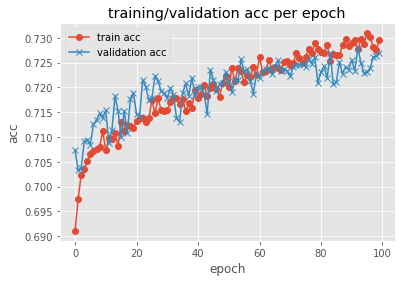

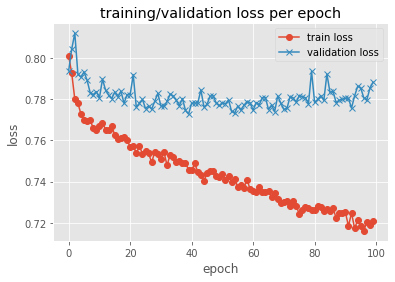

test loss 0.7882, test accuracy 72.68%

labels : 
                    mode  mode_label
0             automobile           0
1                   bike           1
2  public_transportation           2
3                   walk           3

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      4756
           1       0.83      0.78      0.80      2474
           2       0.15      0.36      0.21       667
           3       0.71      0.58      0.64      1365

    accuracy                           0.73      9262
   macro avg       0.65      0.63      0.62      9262
weighted avg       0.80      0.73      0.76      9262

confusion matrix : 
predicted     0     1    2     3   All
actual                                
0          3776   191  143    91  4201
1           204  1921  105    87  2317
2           728   269  241   393  1631
3            48    93  178   794  1113
All        4756  2474  667  1365  9262

confusion matrix (normalize): 
pred

In [ ]:
# run model
calc_model(model, X_train[:, :, :, :4], Y_train, 100, 128, X_test[:, :, :, :4], Y_test, y_labels, True, 'ConvLSTM_model_Ah')

####**convLSTM - 4 layers**

In [ ]:
input_shape = X_train[:, :, :, :4].shape[1:]

x = Input(shape = (input_shape), name = 'mtl_input')

# add convlstm layers
convlstm1 = layers.ConvLSTM2D(128, kernel_size = (2, 2), strides = (1, 1), padding = 'same', return_sequences = True)(x)
# add max pooling layer
pool = layers.MaxPooling3D(pool_size = (1, 1, 1), strides = (1, 1, 1), padding = 'same')(convlstm1)

# add convlstm layers
convlstm2 = layers.ConvLSTM2D(64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', return_sequences = True)(pool)
# add max pooling layer
pool2 = layers.MaxPooling3D(pool_size = (2, 2, 2), strides = (1, 1, 1), padding = 'same')(convlstm2)

# flatten ConvLSTM output so that we can connect it with fully connected layers
flat = layers.Flatten()(pool2)
# fully connected layer
fc = layers.Dense(64, activation = 'relu')(flat)
# add dropout layer
drop = layers.Dropout(0.5)(fc)
# output layer with softmax activation
out = layers.Dense(4, activation = 'softmax', kernel_regularizer = 'l2')(drop)

# create the model
model2 = Model(inputs = x, outputs = [out])

# add optimizer
optimizer = Adam(learning_rate = 0.001)
# compile the model
model2.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mtl_input (InputLayer)       [(None, 1, 75, 4, 1)]     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 1, 75, 4, 128)     264704    
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 75, 4, 128)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 75, 4, 64)      442624    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 75, 4, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 19200)             0         
_________________________________________________________________
dense (Dense)                (None, 64)               

Epoch 1/100
290/290 [==============================] - 55s 188ms/step - loss: 0.7144 - accuracy: 0.7314 - val_loss: 0.6807 - val_accuracy: 0.7454
Epoch 2/100
290/290 [==============================] - 56s 192ms/step - loss: 0.6936 - accuracy: 0.7376 - val_loss: 0.6720 - val_accuracy: 0.7477
Epoch 3/100
290/290 [==============================] - 56s 192ms/step - loss: 0.6872 - accuracy: 0.7397 - val_loss: 0.7067 - val_accuracy: 0.7286
Epoch 4/100
290/290 [==============================] - 55s 190ms/step - loss: 0.6836 - accuracy: 0.7391 - val_loss: 0.6568 - val_accuracy: 0.7533
Epoch 5/100
290/290 [==============================] - 56s 192ms/step - loss: 0.6751 - accuracy: 0.7444 - val_loss: 0.6951 - val_accuracy: 0.7373
Epoch 6/100
290/290 [==============================] - 55s 191ms/step - loss: 0.6669 - accuracy: 0.7466 - val_loss: 0.6460 - val_accuracy: 0.7579
Epoch 7/100
290/290 [==============================] - 54s 185ms/step - loss: 0.6608 - accuracy: 0.7519 - val_loss: 0.6606 -

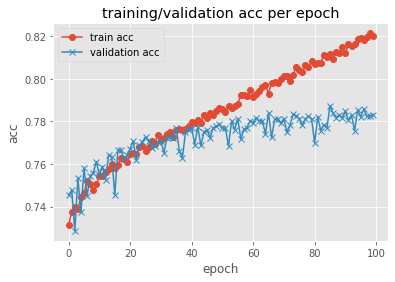

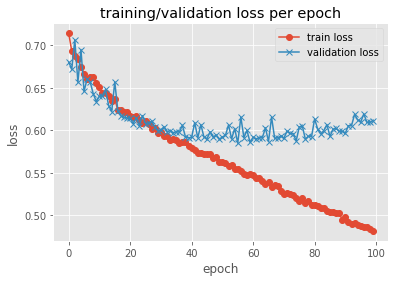

test loss 0.6114, test accuracy 78.31%

labels : 
                    mode  mode_label
0             automobile           0
1                   bike           1
2  public_transportation           2
3                   walk           3

              precision    recall  f1-score   support

           0       0.90      0.83      0.87      4523
           1       0.90      0.88      0.89      2365
           2       0.39      0.52      0.44      1212
           3       0.69      0.66      0.68      1162

    accuracy                           0.78      9262
   macro avg       0.72      0.72      0.72      9262
weighted avg       0.81      0.78      0.79      9262

confusion matrix : 
predicted     0     1     2     3   All
actual                                 
0          3774   117   263    47  4201
1           108  2083    79    47  2317
2           604    99   628   300  1631
3            37    66   242   768  1113
All        4523  2365  1212  1162  9262

confusion matrix (normalize)

In [ ]:
# run model
calc_model(model2, X_train[:, :, :, :4], Y_train, 100, 128, X_test[:, :, :, :4], Y_test, y_labels, True, 'ConvLSTM_model_Bh')

####**ConvLSTM - 6 Layers**

In [ ]:
input_shape = X_train[:, :, :, :4].shape[1:]

x = Input(shape = (input_shape), name = 'mtl_input')
# add convlstm layers
convlstm1 = layers.ConvLSTM2D(128, kernel_size = (2, 2), strides = (1, 1), padding = 'same', return_sequences = True)(x)
# add max pooling layer
pool = layers.MaxPooling3D(pool_size = (1, 1, 1), strides = (1, 1, 1), padding = 'same')(convlstm1)

# add convlstm layers
convlstm2 = layers.ConvLSTM2D(64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', return_sequences = True)(pool)
# add max pooling layer
pool2 = layers.MaxPooling3D(pool_size = (2, 2, 2), strides = (1, 1, 1), padding = 'same')(convlstm2)

# add convlstm layers
convlstm3 = layers.ConvLSTM2D(32, kernel_size = (5, 5), strides = (1, 1), padding = 'same', return_sequences = True)(pool2)
# add max pooling layer
pool3 = layers.MaxPooling3D(pool_size = (4, 4, 4), strides = (1, 1, 1), padding = 'same')(convlstm3)

# flatten ConvLSTM output so that we can connect it with fully connected layers
flat = layers.Flatten()(pool3)
# fully connected layer
fc = layers.Dense(32, activation = 'relu')(flat)
# add dropout layer
drop = layers.Dropout(0.5)(fc)
# output layer with softmax activation
out = layers.Dense(4, activation = 'softmax', kernel_regularizer = 'l2')(drop)

# create the model
model3 = Model(inputs = x, outputs = [out])
# add optimizer
optimizer = Adam(learning_rate = 0.001)
# compile the model
model3.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

model3.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mtl_input (InputLayer)       [(None, 1, 75, 4, 1)]     0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 75, 4, 128)     264704    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 75, 4, 128)     0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 1, 75, 4, 64)      442624    
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 1, 75, 4, 64)      0         
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 1, 75, 4, 32)      307328    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 1, 75, 4, 32)     

Epoch 1/100
290/290 [==============================] - 84s 290ms/step - loss: 1.3079 - accuracy: 0.4524 - val_loss: 1.2849 - val_accuracy: 0.4536
Epoch 2/100
290/290 [==============================] - 80s 275ms/step - loss: 1.0726 - accuracy: 0.5449 - val_loss: 0.7950 - val_accuracy: 0.7037
Epoch 3/100
290/290 [==============================] - 81s 279ms/step - loss: 0.7896 - accuracy: 0.7006 - val_loss: 0.7260 - val_accuracy: 0.7311
Epoch 4/100
290/290 [==============================] - 83s 287ms/step - loss: 0.7572 - accuracy: 0.7149 - val_loss: 0.9309 - val_accuracy: 0.6254
Epoch 5/100
290/290 [==============================] - 82s 284ms/step - loss: 0.7382 - accuracy: 0.7245 - val_loss: 0.6889 - val_accuracy: 0.7435
Epoch 6/100
290/290 [==============================] - 83s 286ms/step - loss: 0.7267 - accuracy: 0.7295 - val_loss: 0.6789 - val_accuracy: 0.7497
Epoch 7/100
290/290 [==============================] - 80s 274ms/step - loss: 0.7222 - accuracy: 0.7287 - val_loss: 0.6714 -

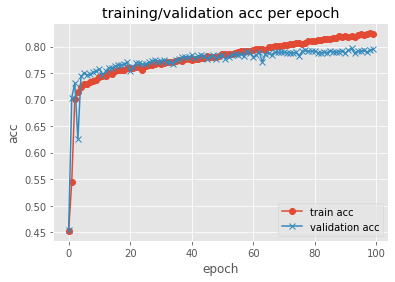

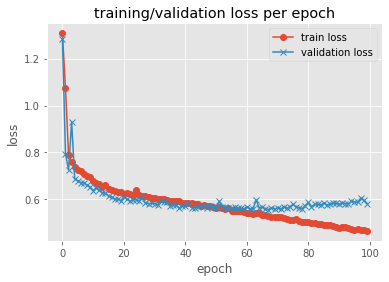

test loss 0.5819, test accuracy 79.45%

labels : 
                    mode  mode_label
0             automobile           0
1                   bike           1
2  public_transportation           2
3                   walk           3

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4544
           1       0.89      0.91      0.90      2283
           2       0.36      0.58      0.44      1012
           3       0.82      0.64      0.72      1423

    accuracy                           0.79      9262
   macro avg       0.74      0.74      0.73      9262
weighted avg       0.83      0.79      0.81      9262

confusion matrix : 
predicted     0     1     2     3   All
actual                                 
0          3796    94   243    68  4201
1           130  2069    64    54  2317
2           580    72   586   393  1631
3            38    48   119   908  1113
All        4544  2283  1012  1423  9262

confusion matrix (normalize)

In [ ]:
# run model
calc_model(model3, X_train[:, :, :, :4], Y_train, 100, 128, X_test[:, :, :, :4], Y_test, y_labels, True, 'ConvLSTM_model_Ch')

####**ConvLSTM - 2 Layers - Split Attributes**

In [ ]:
input_shape1 = X_train[:, :, :, :4].shape[1:]
x1 = Input(shape = (input_shape1), name = 'mtl_input')

input_shape2 = aux_train.shape[1:]
x2 = Input(shape = (input_shape2), name = 'aux_input')

# add convlstm layers
convlstm = layers.ConvLSTM2D(128, kernel_size = (2, 2), strides = (1, 1), padding = 'same', return_sequences = True)(x1)
# add max pooling layer
pool = layers.MaxPooling3D(pool_size = (1, 1, 1), strides = (1, 1, 1), padding = 'same')(convlstm)

# add aux input
aux1 = layers.Dense(128, activation = 'relu')(x2)

# flatten LSTM output so that we can connect it with fully connected layers
flat1 = layers.Flatten()(pool)
flat2 = layers.Flatten()(aux1)

# merge
merge = concatenate([flat1, flat2])

# fully connected layer
fc = layers.Dense(128, activation = 'relu')(merge)
# add dropout layer
drop = layers.Dropout(0.5)(fc)
# output layer with softmax activation
out = layers.Dense(4, activation = 'softmax', kernel_regularizer = 'l2')(drop)

# create the model
model_split = Model(inputs = [x1, x2], outputs = [out])
# add optimizer
optimizer = Adam(learning_rate = 0.001)
# compile the model
model_split.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

model_split.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mtl_input (InputLayer)          [(None, 1, 75, 4, 1) 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 1, 75, 4, 128 264704      mtl_input[0][0]                  
__________________________________________________________________________________________________
aux_input (InputLayer)          [(None, 1, 1, 8, 1)] 0                                            
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 1, 75, 4, 128 0           conv_lst_m2d[0][0]               
_______________________________________________________________________________________

Epoch 1/100
290/290 [==============================] - 14s 49ms/step - loss: 1.2996 - accuracy: 0.4519 - val_loss: 1.2565 - val_accuracy: 0.4536
Epoch 2/100
290/290 [==============================] - 14s 47ms/step - loss: 1.1754 - accuracy: 0.4586 - val_loss: 1.0781 - val_accuracy: 0.4940
Epoch 3/100
290/290 [==============================] - 14s 47ms/step - loss: 1.0400 - accuracy: 0.5271 - val_loss: 0.9921 - val_accuracy: 0.6081
Epoch 4/100
290/290 [==============================] - 14s 48ms/step - loss: 0.9841 - accuracy: 0.6037 - val_loss: 0.9456 - val_accuracy: 0.6576
Epoch 5/100
290/290 [==============================] - 14s 49ms/step - loss: 0.9486 - accuracy: 0.6330 - val_loss: 0.9132 - val_accuracy: 0.6669
Epoch 6/100
290/290 [==============================] - 14s 49ms/step - loss: 0.9232 - accuracy: 0.6510 - val_loss: 0.8879 - val_accuracy: 0.6726
Epoch 7/100
290/290 [==============================] - 14s 49ms/step - loss: 0.9042 - accuracy: 0.6583 - val_loss: 0.8699 - val_ac

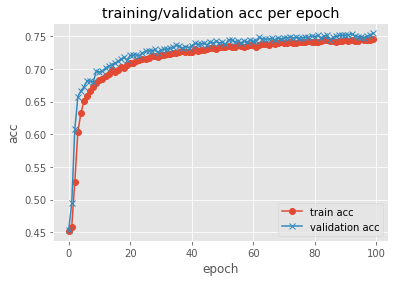

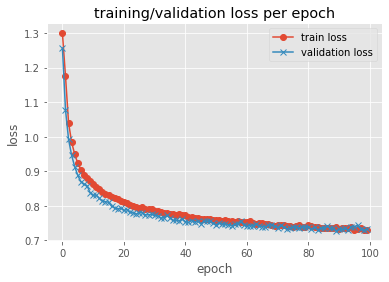

test loss 0.7319, test accuracy 75.48%

labels : 
                    mode  mode_label
0             automobile           0
1                   bike           1
2  public_transportation           2
3                   walk           3

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      4596
           1       0.81      0.75      0.78      2528
           2       0.27      0.64      0.38       700
           3       0.85      0.66      0.74      1438

    accuracy                           0.75      9262
   macro avg       0.71      0.71      0.69      9262
weighted avg       0.81      0.75      0.78      9262

confusion matrix : 
predicted     0     1    2     3   All
actual                                
0          3712   243  130   116  4201
1           212  1886   99   120  2317
2           634   292  448   257  1631
3            38   107   23   945  1113
All        4596  2528  700  1438  9262

confusion matrix (normalize): 
pred

In [ ]:
# run model
calc_model_split(model_split, X_train[:, :, :, :4], aux_train, Y_train, 100, 128, X_test[:, :, :, :4], aux_test, Y_test, y_labels, True, 'ConvLSTM_model_Ah_split')

####**ConvLSTM - 4 Layers - Split Attributes**

In [ ]:
input_shape1 = X_train[:, :, :, :4].shape[1:]
x1 = Input(shape = (input_shape1), name = 'mtl_input')

input_shape2 = aux_train.shape[1:]
x2 = Input(shape = (input_shape2), name = 'aux_input')

# add convlstm layers
convlstm = layers.ConvLSTM2D(128, kernel_size = (2, 2), strides = (1, 1), padding = 'same', return_sequences = True)(x1)
# add max pooling layer
pool = layers.MaxPooling3D(pool_size = (1, 1, 1), strides = (1, 1, 1), padding = 'same')(convlstm)
# add convlstm layers
convlstm2 = layers.ConvLSTM2D(64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', return_sequences = True)(pool)
# add max pooling layer
pool2 = layers.MaxPooling3D(pool_size = (2, 2, 2), strides = (1, 1, 1), padding = 'same')(convlstm2)

# add aux input
aux1 = layers.Dense(128, activation = 'relu')(x2)
aux2 = layers.Dense(64, activation = 'relu')(aux1)

# flatten LSTM output so that we can connect it with fully connected layers
flat1 = layers.Flatten()(pool2)
flat2 = layers.Flatten()(aux2)

# merge
merge = concatenate([flat1, flat2])

# fully connected layer
fc = layers.Dense(64, activation = 'relu')(merge)
# add dropout layer
drop = layers.Dropout(0.5)(fc)
# output layer with softmax activation
out = layers.Dense(4, activation = 'softmax', kernel_regularizer = 'l2')(drop)

# create the model
model_split4 = Model(inputs = [x1, x2], outputs = [out])
# add optimizer
optimizer = Adam(learning_rate = 0.001)
# compile the model
model_split4.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

model_split4.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mtl_input (InputLayer)          [(None, 1, 75, 4, 1) 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 1, 75, 4, 128 264704      mtl_input[0][0]                  
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 1, 75, 4, 128 0           conv_lst_m2d[0][0]               
__________________________________________________________________________________________________
aux_input (InputLayer)          [(None, 1, 1, 8, 1)] 0                                            
_______________________________________________________________________________________

Epoch 1/100
290/290 [==============================] - 25s 85ms/step - loss: 1.3062 - accuracy: 0.4526 - val_loss: 1.2646 - val_accuracy: 0.4536
Epoch 2/100
290/290 [==============================] - 24s 83ms/step - loss: 1.1022 - accuracy: 0.4984 - val_loss: 0.9458 - val_accuracy: 0.6343
Epoch 3/100
290/290 [==============================] - 24s 82ms/step - loss: 0.9392 - accuracy: 0.6378 - val_loss: 0.8759 - val_accuracy: 0.6715
Epoch 4/100
290/290 [==============================] - 24s 82ms/step - loss: 0.8887 - accuracy: 0.6673 - val_loss: 0.8555 - val_accuracy: 0.6848
Epoch 5/100
290/290 [==============================] - 24s 82ms/step - loss: 0.8653 - accuracy: 0.6801 - val_loss: 0.8807 - val_accuracy: 0.6720
Epoch 6/100
290/290 [==============================] - 24s 82ms/step - loss: 0.8477 - accuracy: 0.6886 - val_loss: 0.7925 - val_accuracy: 0.7203
Epoch 7/100
290/290 [==============================] - 24s 82ms/step - loss: 0.8342 - accuracy: 0.6934 - val_loss: 0.7862 - val_ac

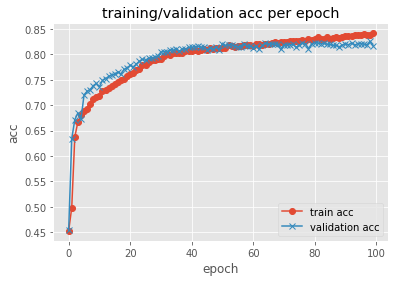

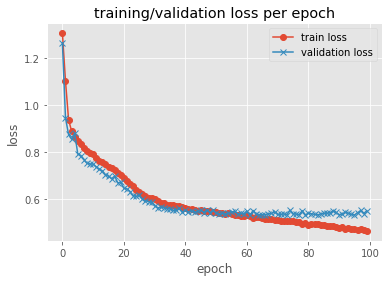

test loss 0.5517, test accuracy 81.69%

labels : 
                    mode  mode_label
0             automobile           0
1                   bike           1
2  public_transportation           2
3                   walk           3

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4854
           1       0.85      0.94      0.89      2112
           2       0.42      0.68      0.52      1020
           3       0.87      0.76      0.81      1276

    accuracy                           0.82      9262
   macro avg       0.77      0.80      0.77      9262
weighted avg       0.85      0.82      0.83      9262

confusion matrix : 
predicted     0     1     2     3   All
actual                                 
0          3930    49   165    57  4201
1           172  1980   101    64  2317
2           706    44   691   190  1631
3            46    39    63   965  1113
All        4854  2112  1020  1276  9262

confusion matrix (normalize)

In [ ]:
# run model
calc_model_split(model_split4, X_train[:, :, :, :4], aux_train, Y_train, 100, 128, X_test[:, :, :, :4], aux_test, Y_test, y_labels, True, 'ConvLSTM_model_Bh_split')

####**ConvLSTM - 6 Layers - Split Attributes**

In [15]:
input_shape1 = X_train[:, :, :, :4].shape[1:]
x1 = Input(shape = (input_shape1), name = 'mtl_input')

input_shape2 = aux_train.shape[1:]
x2 = Input(shape = (input_shape2), name = 'aux_input')

# add convlstm layers
convlstm1 = layers.ConvLSTM2D(128, kernel_size = (2, 2), strides = (1, 1), padding = 'same', return_sequences = True)(x1)
# add max pooling layer
pool = layers.MaxPooling3D(pool_size = (1, 1, 1), strides = (1, 1, 1), padding = 'same')(convlstm1)

# add convlstm layers
convlstm2 = layers.ConvLSTM2D(64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', return_sequences = True)(pool)
# add max pooling layer
pool2 = layers.MaxPooling3D(pool_size = (2, 2, 2), strides = (1, 1, 1), padding = 'same')(convlstm2)

# add convlstm layers
convlstm3 = layers.ConvLSTM2D(32, kernel_size = (5, 5), strides = (1, 1), padding = 'same', return_sequences = True)(pool2)
# add max pooling layer
pool3 = layers.MaxPooling3D(pool_size = (4, 4, 4), strides = (1, 1, 1), padding = 'same')(convlstm3)

# add aux input
aux1 = layers.Dense(128, activation = 'relu')(x2)
aux2 = layers.Dense(64, activation = 'relu')(aux1)
aux3 = layers.Dense(32, activation = 'relu')(aux2)

# flatten LSTM output so that we can connect it with fully connected layers
flat1 = layers.Flatten()(pool3)
flat2 = layers.Flatten()(aux3)

# merge
merge = concatenate([flat1, flat2])

# fully connected layer
fc = layers.Dense(32, activation = 'relu')(merge)
# add dropout layer
drop = layers.Dropout(0.5)(fc)
# output layer with softmax activation
out = layers.Dense(4, activation = 'softmax', kernel_regularizer = 'l2')(drop)

# create the model
model_split6 = Model(inputs = [x1, x2], outputs = [out])
# add optimizer
optimizer = Adam(learning_rate = 0.001)
# compile the model
model_split6.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

model_split6.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mtl_input (InputLayer)          [(None, 1, 75, 4, 1) 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 1, 75, 4, 128 264704      mtl_input[0][0]                  
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 1, 75, 4, 128 0           conv_lst_m2d[0][0]               
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 1, 75, 4, 64) 442624      max_pooling3d[0][0]              
_______________________________________________________________________________________

Epoch 1/100
290/290 [==============================] - 34s 118ms/step - loss: 1.3183 - accuracy: 0.4483 - val_loss: 1.2818 - val_accuracy: 0.4536
Epoch 2/100
290/290 [==============================] - 33s 114ms/step - loss: 1.1103 - accuracy: 0.5142 - val_loss: 0.8788 - val_accuracy: 0.6996
Epoch 3/100
290/290 [==============================] - 33s 113ms/step - loss: 0.8319 - accuracy: 0.6713 - val_loss: 0.7245 - val_accuracy: 0.7339
Epoch 4/100
290/290 [==============================] - 33s 114ms/step - loss: 0.7679 - accuracy: 0.7130 - val_loss: 0.7138 - val_accuracy: 0.7394
Epoch 5/100
290/290 [==============================] - 33s 114ms/step - loss: 0.7512 - accuracy: 0.7222 - val_loss: 0.6913 - val_accuracy: 0.7435
Epoch 6/100
290/290 [==============================] - 33s 114ms/step - loss: 0.7314 - accuracy: 0.7283 - val_loss: 0.6841 - val_accuracy: 0.7449
Epoch 7/100
290/290 [==============================] - 33s 114ms/step - loss: 0.7280 - accuracy: 0.7300 - val_loss: 0.6832 -

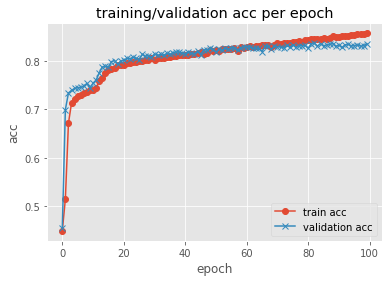

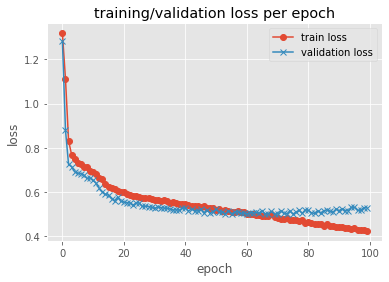

test loss 0.5282, test accuracy 83.63%

labels : 
                    mode  mode_label
0             automobile           0
1                   bike           1
2  public_transportation           2
3                   walk           3

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      4542
           1       0.89      0.93      0.91      2232
           2       0.51      0.71      0.60      1185
           3       0.89      0.76      0.82      1303

    accuracy                           0.84      9262
   macro avg       0.80      0.81      0.80      9262
weighted avg       0.86      0.84      0.84      9262

confusion matrix : 
predicted     0     1     2     3   All
actual                                 
0          3854    70   217    60  4201
1           111  2066    79    61  2317
2           535    64   838   194  1631
3            42    32    51   988  1113
All        4542  2232  1185  1303  9262

confusion matrix (normalize)

In [ ]:
# run model
calc_model_split(model_split6, X_train[:, :, :, :4], aux_train, Y_train, 100, 128, X_test[:, :, :, :4], aux_test, Y_test, y_labels, True, 'ConvLSTM_model_Ch_split')

Epoch 1/100
145/145 [==============================] - 81s 559ms/step - loss: 1.3370 - accuracy: 0.4445 - val_loss: 1.2961 - val_accuracy: 0.4536
Epoch 2/100
145/145 [==============================] - 77s 534ms/step - loss: 1.2950 - accuracy: 0.4529 - val_loss: 1.2605 - val_accuracy: 0.4536
Epoch 3/100
145/145 [==============================] - 77s 531ms/step - loss: 1.0567 - accuracy: 0.5487 - val_loss: 0.8444 - val_accuracy: 0.6955
Epoch 4/100
145/145 [==============================] - 77s 532ms/step - loss: 0.8251 - accuracy: 0.6861 - val_loss: 0.8692 - val_accuracy: 0.6444
Epoch 5/100
145/145 [==============================] - 77s 530ms/step - loss: 0.7999 - accuracy: 0.6965 - val_loss: 0.7202 - val_accuracy: 0.7374
Epoch 6/100
145/145 [==============================] - 77s 534ms/step - loss: 0.7581 - accuracy: 0.7195 - val_loss: 0.7050 - val_accuracy: 0.7377
Epoch 7/100
145/145 [==============================] - 78s 538ms/step - loss: 0.7476 - accuracy: 0.7224 - val_loss: 0.6921 -

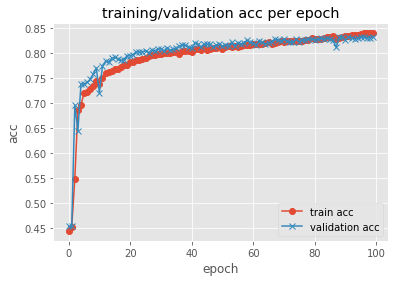

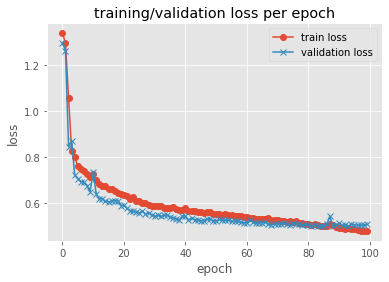

test loss 0.5058, test accuracy 83.18%

labels : 
                    mode  mode_label
0             automobile           0
1                   bike           1
2  public_transportation           2
3                   walk           3

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      4667
           1       0.89      0.93      0.91      2218
           2       0.47      0.70      0.56      1102
           3       0.88      0.76      0.82      1275

    accuracy                           0.83      9262
   macro avg       0.79      0.81      0.79      9262
weighted avg       0.86      0.83      0.84      9262

confusion matrix : 
predicted     0     1     2     3   All
actual                                 
0          3900    58   186    57  4201
1           119  2059    91    48  2317
2           610    54   771   196  1631
3            38    47    54   974  1113
All        4667  2218  1102  1275  9262

confusion matrix (normalize)

In [16]:
# run model
calc_model_split(model_split6, X_train[:, :, :, :4], aux_train, Y_train, 100, 256, X_test[:, :, :, :4], aux_test, Y_test, y_labels, True, 'ConvLSTM_model_Ch_split')